<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/BTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!gdown 1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
!gdown 1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 151, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 203, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'


In [100]:
import gdown
gdown.download('https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw', 'images.npy', quiet=False)
gdown.download('https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx', 'tip.npy', quiet=False)

Downloading...
From: https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
To: /content/images.npy
84.2kB [00:00, 2.63MB/s]
Downloading...
From: https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
To: /content/tip.npy
84.2kB [00:00, 2.67MB/s]


'tip.npy'

In [415]:
import numpy as np
images = np.load('/content/images.npy')
tip = np.load('/content/tip.npy')
surfaces = np.load('/content/surfs.npy')

In [383]:
import torch


def compute_xc_yc(tip):
    tip_xsiz, tip_ysiz = tip.size()
    xc = round(tip_xsiz / 2)
    yc = round(tip_ysiz / 2)
    return xc, yc


def idilation(surface, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    surface = surface.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    surf_xsiz, surf_ysiz = surface.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(surface, -float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the dilation operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(surface, shifts=(-px, -py), dims=(0, 1))
            temp = temp + tip[xc + px, yc + py]
            r = torch.maximum(r, temp)

    return r


def ierosion(image, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    im_xsiz, im_ysiz = image.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(image, float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the erosion operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(image, shifts=(px, py), dims=(0, 1))
            temp = temp - tip[xc + px, yc + py]
            r = torch.minimum(r, temp)

    return r


def translate_tip_mean(P, cutoff=10**(-8)):
    # Ensure P is on GPU
    P = P.to('cuda' if torch.cuda.is_available() else 'cpu')

    tip_xsiz, tip_ysiz = P.size()
    xc, yc = compute_xc_yc(P)

    #p_max = torch.min(P)
    #P = P - p_max

    p_min = torch.min(P)
    weight = P - p_min
    weight = weight

    id = weight < cutoff
    weight[id] = 0.0

    if torch.all(weight < 10**(-10)):
        #print('called')
        weight.fill_(1.0)

    ix = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    iy = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    ix = torch.cumsum(ix, dim=0) - 1.0
    iy = torch.cumsum(iy, dim=1) - 1.0
    com_x = torch.sum(ix * weight / torch.sum(weight))
    com_y = torch.sum(iy * weight / torch.sum(weight))
    id_x = round(com_x.item())
    id_y = round(com_y.item())

    pxmin = max(- xc, - id_x)
    pymin = max(- yc, - id_y)
    pxmax = min(tip_xsiz - xc, tip_xsiz - id_x)
    pymax = min(tip_ysiz - yc, tip_ysiz - id_y)

    #print(id_x, id_y)
    P_new = torch.full_like(P, p_min.item())
    P_new[(xc + pxmin):(xc + pxmax), (yc + pymin):(yc + pymax)] = P[(id_x + pxmin):(id_x + pxmax), (id_y + pymin):(id_y + pymax)]

    return P_new


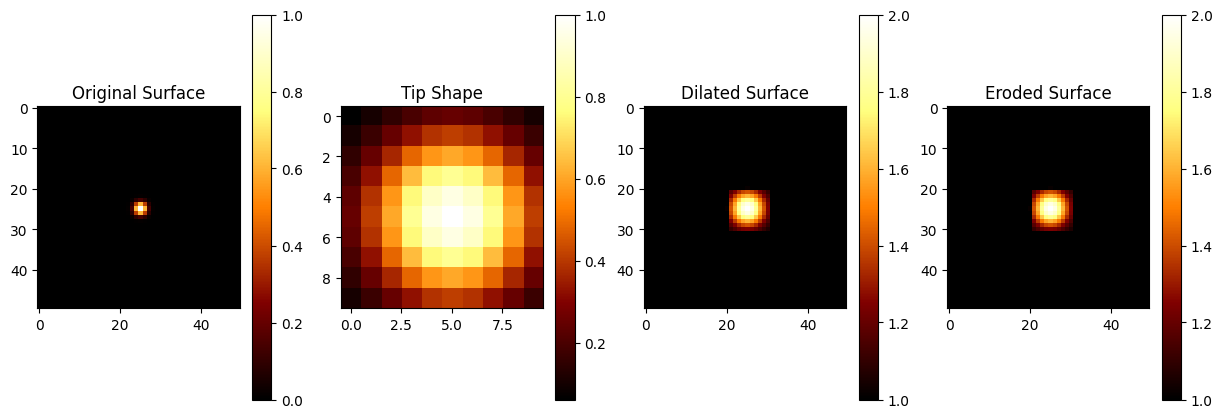

In [384]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(x_size, y_size, x_mean, y_mean, x_sigma, y_sigma):
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)
    return np.exp(-((x - x_mean) ** 2 / (2 * x_sigma ** 2) + (y - y_mean) ** 2 / (2 * y_sigma ** 2)))

# Sample surface and tip
surface_size = (50, 50)
tip_size = (10, 10)

surface = gaussian_2d(surface_size[0], surface_size[1], surface_size[0] / 2, surface_size[1] / 2, 1, 1)
tip = gaussian_2d(tip_size[0], tip_size[1], tip_size[0] / 2, tip_size[1] / 2, 3, 3)

# Convert to torch tensors
surface_tensor = torch.tensor(surface, dtype=torch.float32)
tip_tensor = torch.tensor(tip, dtype=torch.float32)

# Perform dilation
dilated_surface = idilation(surface_tensor, tip_tensor)

# Perform erosion
eroded_surface = idilation(ierosion(dilated_surface, tip_tensor), tip_tensor)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(surface, cmap='afmhot')
plt.title('Original Surface')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(tip, cmap='afmhot')
plt.title('Tip Shape')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(dilated_surface.cpu().numpy(), cmap='afmhot')
plt.title('Dilated Surface')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(eroded_surface.cpu().numpy(), cmap='afmhot')
plt.title('Eroded Surface')
plt.colorbar()

plt.show()

In [397]:
surface = surfaces[1, :, :]
image = images[1, :, :]

In [386]:
image2_tensor = idilation(surface_tensor, tip_tensor)

In [387]:
image.shape

(30, 30)

In [388]:
surface.shape

(30, 30)

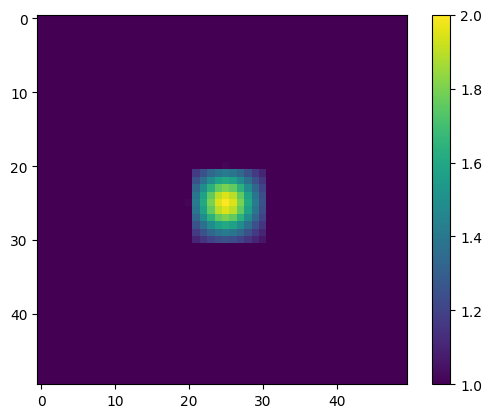

In [389]:
plt.imshow(image2_tensor.detach().cpu())
plt.colorbar()

In [420]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 1000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image2_tensor = idilation(surface_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((image2_tensor - image_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 6.229384422302246
Iteration 100, Loss: 0.11259995400905609
Iteration 200, Loss: 0.08684130758047104
Iteration 300, Loss: 0.08670951426029205
Iteration 400, Loss: 0.08664611726999283
Iteration 500, Loss: 0.08664703369140625
Iteration 600, Loss: 0.08665096759796143
Iteration 700, Loss: 0.08665858209133148
Iteration 800, Loss: 0.08665179461240768
Iteration 900, Loss: 0.08664148300886154


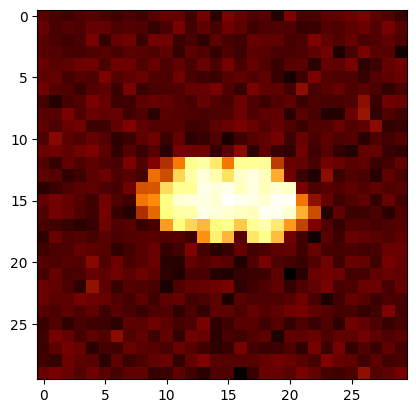

In [421]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.imshow(image_tensor.cpu(), cmap='afmhot')

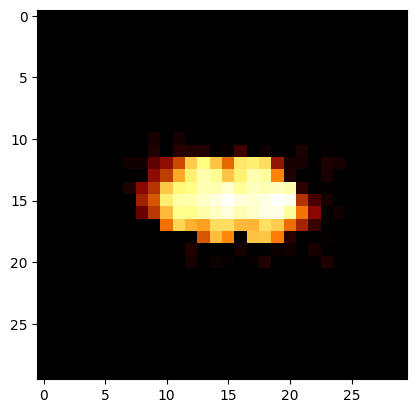

In [422]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

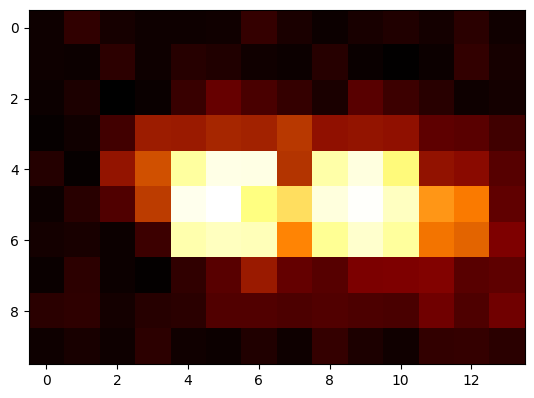

In [423]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip_estimate, cmap='afmhot')

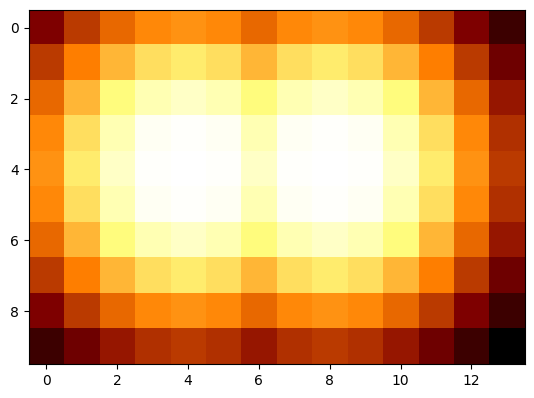

In [424]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip, cmap='afmhot')

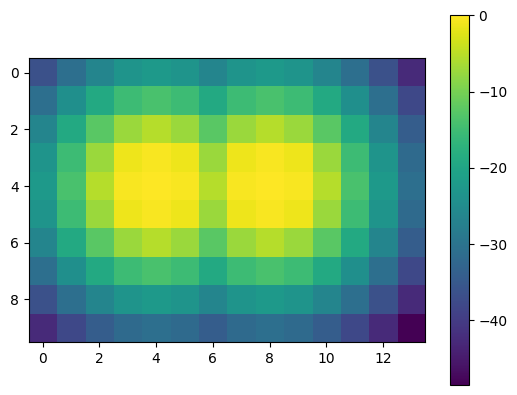

In [425]:
plt.imshow(tip)
plt.colorbar()

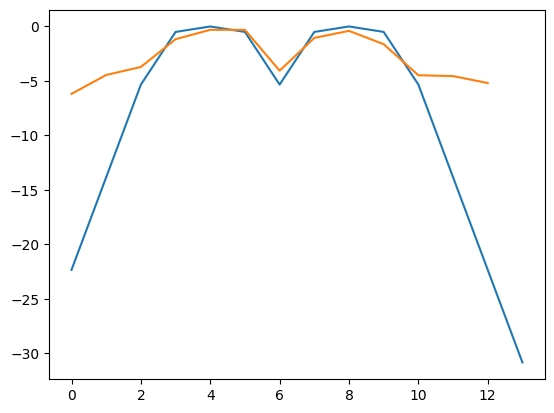

In [428]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.plot(tip[4, :])
plt.plot(tip_estimate[4, 1:])

In [429]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 1000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    surface2_tensor = ierosion(image_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((surface2_tensor - surface_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 1.3388584852218628
Iteration 100, Loss: 0.15699467062950134
Iteration 200, Loss: 0.08713163435459137
Iteration 300, Loss: 0.07879184186458588
Iteration 400, Loss: 0.07731862366199493
Iteration 500, Loss: 0.07404652237892151
Iteration 600, Loss: 0.07176375389099121
Iteration 700, Loss: 0.071634441614151
Iteration 800, Loss: 0.07164325565099716
Iteration 900, Loss: 0.0716453418135643


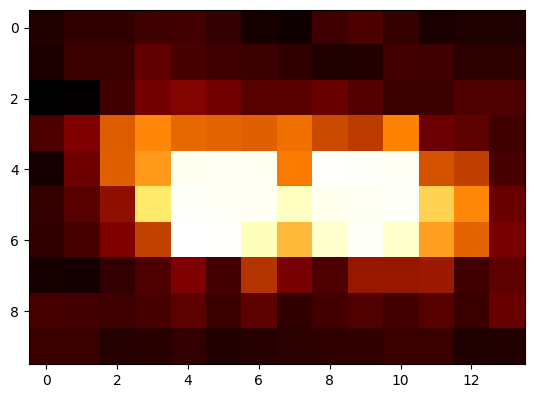

In [408]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip_estimate, cmap='afmhot')

In [409]:
import torch
import torch.optim as optim
import numpy as np

tip_size = tip.shape
image_tensor = torch.tensor(surface, dtype=torch.float32)

tip0 = tip
tip0_tensor = torch.tensor(tip0, dtype=torch.float32)
dilated0_surface = idilation(surface_tensor, tip0_tensor)

# Initialize tip with random values
tip_tensor = torch.zeros(tip_size, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 1000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    dilated_surface = idilation(surface_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((dilated0_surface - dilated_surface) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
optimized_tip = tip_tensor.detach().numpy()


Iteration 0, Loss: 6.097305774688721
Iteration 10, Loss: 3.8779959678649902
Iteration 20, Loss: 2.3137495517730713
Iteration 30, Loss: 1.3104345798492432
Iteration 40, Loss: 0.719831645488739
Iteration 50, Loss: 0.39108434319496155
Iteration 60, Loss: 0.21409514546394348
Iteration 70, Loss: 0.12002935260534286
Iteration 80, Loss: 0.07035320997238159
Iteration 90, Loss: 0.043170031160116196
Iteration 100, Loss: 0.02734644152224064
Iteration 110, Loss: 0.0175962895154953
Iteration 120, Loss: 0.011514759622514248
Iteration 130, Loss: 0.00758728664368391
Iteration 140, Loss: 0.005040143150836229
Iteration 150, Loss: 0.0033857596572488546
Iteration 160, Loss: 0.0023049323353916407
Iteration 170, Loss: 0.0015983462799340487
Iteration 180, Loss: 0.0011276702862232924
Iteration 190, Loss: 0.0008136875694617629
Iteration 200, Loss: 0.0005988006014376879
Iteration 210, Loss: 0.00045083838631398976
Iteration 220, Loss: 0.000346830376656726
Iteration 230, Loss: 0.0002716099552344531
Iteration 240,

In [249]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
import copy

lambda_my = 0.00001
lr_my = 1.0
nepoch = 10

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

# CustomModelを作成
class CustomModel(torch.nn.Module):
    def __init__(self, tip):
        super(CustomModel, self).__init__()
        nx, ny = tip.shape
        initial_tip = torch.zeros((nx, ny), dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        initial_tip = initial_tip.to(device)
        self.P = torch.nn.Parameter(initial_tip)

    def forward(self, x):
        return idilation(ierosion(x, self.P), self.P)

m = CustomModel(tip)

def loss_fn(image):
    return torch.nn.functional.mse_loss(m.forward(image), image, reduction='mean')

optimizer = AdamW(m.parameters(), lr=lr_my, weight_decay=lambda_my)

In [250]:
x = next(iter(data_loader))

In [251]:
loss = loss_fn(x[0])

In [252]:
loss

tensor(5.6080, device='cuda:0', grad_fn=<MseLossBackward0>)

In [253]:
loss.backward()

In [254]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.0
    maximize: False
    weight_decay: 1e-05
)

In [255]:
loss_train = []
for epoch in range(nepoch):
    loss_tmp = 0.0
    for x in data_loader:
        optimizer.zero_grad()
        loss = loss_fn(x[0])
        loss.backward()
        optimizer.step()
        #with torch.no_grad():
            #m.P.data = torch.clamp(m.P, max=0.0)
            #m.P.data = translate_tip_mean(m.P)
        loss_tmp += loss_fn(x[0]).item()

    print(epoch, loss_tmp)
    loss_train.append(loss_tmp)

tip_estimate = m.P.detach().to('cpu').numpy()

0 95.3866126537323
1 95.3866126537323
2 95.3866126537323
3 95.3866126537323
4 95.3866126537323
5 95.3866126537323
6 95.3866126537323
7 95.3866126537323
8 95.3866126537323
9 95.3866126537323


In [263]:
tip_estimate = m.P.detach().to('cpu').numpy()

In [264]:
tip_estimate

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [268]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
import copy

lambda_my = 0.00001
lr_my = 10.0
nepoch = 10

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

tip_estimate = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tip_estimate = tip_estimate.to(device)

#optimizer = AdamW([tip_estimate], lr=lr_my, weight_decay=lambda_my)
optimizer = optim.Adam([tip_estimate], lr=lr_my)

def loss_fn(image):
    return torch.mean((idilation(ierosion(image, tip_estimate), tip_estimate) - image)**2)

ValueError: can't optimize a non-leaf Tensor

In [274]:
tip_tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       requires_grad=True)

In [433]:
import torch
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(images[0, :, :], dtype=torch.float32)
image_tensor = image_tensor.to(device)

# Initialize tip with random values
tip_size = tip.shape
tip_tensor = torch.rand(tip_size, dtype=torch.float64, requires_grad=True, device=device)

# Optimization settings
optimizer = optim.Adam([tip_tensor], lr=1.0)
num_iterations = 100

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
    #print(torch.max(image_reconstructed))

    # Calculate MSE loss
    loss = torch.mean((image_reconstructed - image_tensor)**2)

    # Backpropagation
    loss.backward()
    #print(tip_tensor.grad)

    # Update tip
    optimizer.step()

    with torch.no_grad():
        tip_tensor.data = torch.clamp(tip_tensor, max=0.0)
        tip_tensor.data = translate_tip_mean(tip_tensor)

    # Optional: print loss every few iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().to('cpu').numpy()

Iteration 0, Loss: 5.956843852996826
Iteration 10, Loss: 5.940250873565674
Iteration 20, Loss: 5.285327911376953
Iteration 30, Loss: 3.506157636642456
Iteration 40, Loss: 2.755160331726074
Iteration 50, Loss: 2.4642629623413086
Iteration 60, Loss: 2.0682034492492676
Iteration 70, Loss: 1.809455156326294
Iteration 80, Loss: 1.4451649188995361
Iteration 90, Loss: 1.4516417980194092


tensor(6.0454, device='cuda:0', grad_fn=<MaxBackward1>)


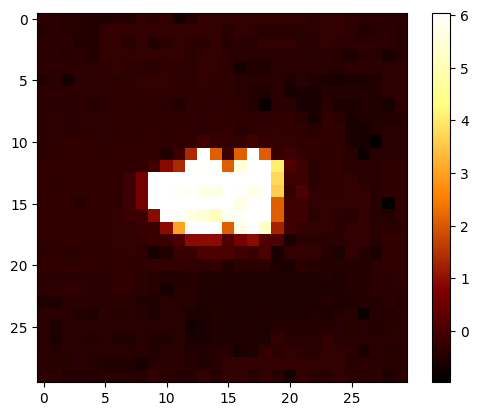

In [434]:
image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
plt.imshow(image_reconstructed.detach().cpu(), cmap='afmhot')
plt.colorbar()
print(torch.max(image_reconstructed))

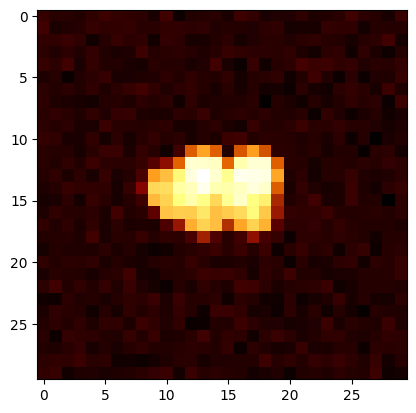

In [435]:
plt.imshow(image_tensor.cpu(), cmap='afmhot')

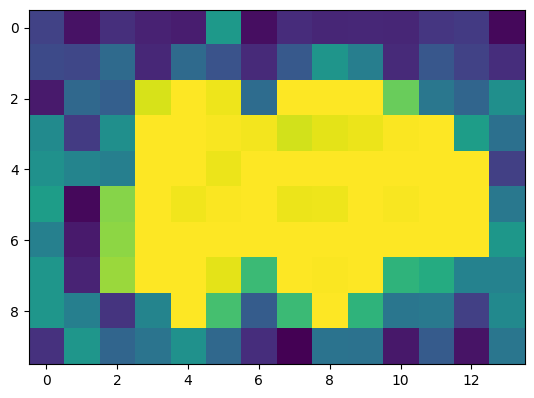

In [436]:
plt.imshow(tip_estimate)